In [1]:
from pathlib import Path
import random
import os
from importlib import reload

import warnings
# Ignore PyTorch's KLDivLoss warning
warnings.simplefilter("ignore", category=UserWarning, lineno=2949)

import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
from tqdm.auto import tqdm

In [8]:
import utils.config
reload(utils.config)
from utils.config import BASE_PATH, SPEC_DIR, DEVICE
from utils.data_handling import metadata_df

class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

metadata = metadata_df("train")
display(metadata.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,eeg_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,data/eegs_npy/train_spectrograms/353733npy,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,data/eegs_npy/train_spectrograms/353733npy,0


In [9]:
DEVICE

'cuda'

In [4]:
from utils import SpectrogramDataset
valid_frac = 0.1
num_unique_spectrograms = metadata.spectrogram_id.unique().shape[0]
valid_num = round(valid_frac * num_unique_spectrograms)
print(f"{num_unique_spectrograms} unique spectrograms, using {valid_num} for validation set.")

rng = np.random.default_rng(seed=4)
valid_set = rng.choice(metadata.spectrogram_id.unique(), size=valid_num, replace=False)
metadata_train = metadata[~metadata.spectrogram_id.isin(valid_set)]
metadata_valid = metadata[metadata.spectrogram_id.isin(valid_set)]
print(f"{len(metadata_train)} training items, {len(metadata_valid)} validation items.")

train_small = SpectrogramDataset(metadata_train, n_items=5000, preloaded=True, random_state=4)
valid_small = SpectrogramDataset(metadata_valid, n_items=1000, preloaded=True, random_state=4)
print(f"{len(train_small)} training items, {len(valid_small)} validation items.")

11138 unique spectrograms, using 1114 for validation set.
95346 training items, 11454 validation items.
5000 training items, 1000 validation items.


In [5]:
import torchvision
auto_tfms = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
auto_tfms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
from torchvision import transforms
manual_tfms = transforms.Compose([
    lambda x: x.unsqueeze(0).repeat(3,1,1),  # convert to RGB
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    # EffnetB0 expects size [224, 224] images. But I won't center-crop, since
    # this leaves out too much data from LL and RP.
    lambda x: torch.clamp(x, 1e-4, 1e7),  # avoid log(0) errors
    torch.log,                            # log-scale as in visualization
    lambda x: (x - x.min()) / x.max(),    # scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # normalization from EffnetB0 transforms
])

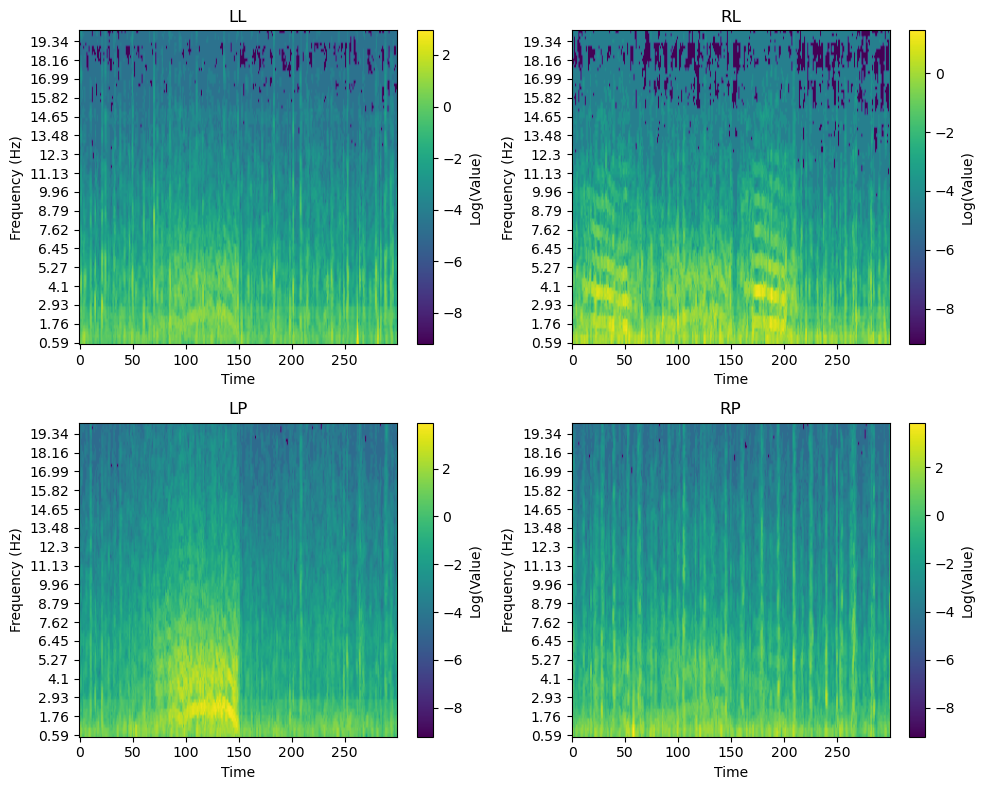

In [7]:
from utils.visualization import visualize_spectrogram
idx = random.randint(0, len(train_small))
orig = train_small[idx][0]
visualize_spectrogram(orig)

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_small, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=32)

In [8]:
import utils.models
reload(utils.models)
from utils.training import Trainer
from utils.models import Spectrogram_EfficientNet
from utils.config import DEVICE

model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
trainer = Trainer(model, train_loader, valid_loader)



In [9]:
trainer.time_train_step(1000)
trainer.time_val_step(1000)

Trained on 1000 batches in 58.67s.
Predicted on 1000 validation batches in 28.34s.


1000

I now want to visualize the effects of a few hyperparameters on training. In rough order of complexity:
1. Normalizing vs. not normalizing the targets.
    - The loss can't truly be compared between the two situations. However, getting a more "realistic" loss in the normalized case will provide independent confirmation that normalizing is correct.
    - Training should differ between the two situations: if normalizing is correct, then training on the unnormalized dataset will assign too much influence to training examples with a large number of evaluators.
2. `nn.KLDivLoss(reduction="mean")` vs. `nn.KLDivLoss(reduction="batchmean")`.
    - This should just multiply everything by a scalar. I think that `reduction="mean"` is correct.
3. Different optimizers (I will use SGD, Adam, and AdamW).
4. Freezing vs. not freezing the pretrained weights.
5. Changing batch sizes (I will try 16, 32, and 64).
    - To get a fair comparison, I'll scale the training length so that we train on the same number of examples, total.
6. Increasing the size of the training set.
7. Using discriminative learning rates for the pretrained weights.
8. Using more complex pretrained models.

For 1-5, I'll use the following default values for the hyperparameters not being tested:
- constant dataset of 5000 training items and 1000 validation items,
- the same random state for dataloading,
- normalized targets,
- `reduction="mean"`,
- AdamW optimizer with learning rate chosen via the learning rate finder and other parameters at default,
- Unfrozen weights,
- Batch size = 32.

  0%|          | 0/300 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.29E-04


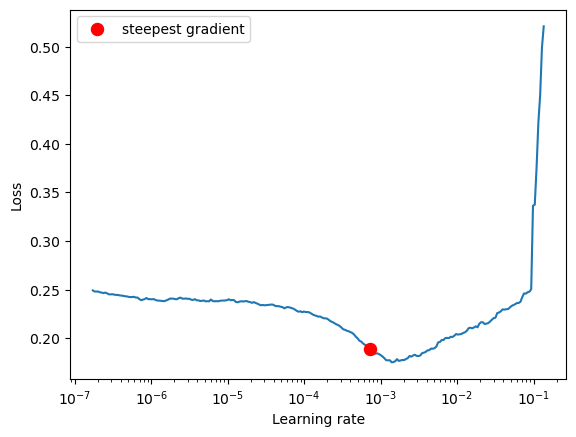

In [16]:
# Defaults
from utils import Spectrogram_EfficientNet, SpectrogramDataset
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader
train_small = SpectrogramDataset(metadata_train, n_items=5000,
                                 preloaded=True, normalize_targets=True, random_state=4)
valid_small = SpectrogramDataset(metadata_valid, n_items=1000,
                                 preloaded=True, normalize_targets=True, random_state=4)

batch_size = 32
torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)

model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7)
loss_fn = torch.nn.KLDivLoss(reduction="mean")
lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=300)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_mean_reduction_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_batchmean_reduction_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_unnormalized_targets_mean_reduction_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_unnormalized_targets_batchmean_reduction_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Unnormalized targets, batchmean reduction')

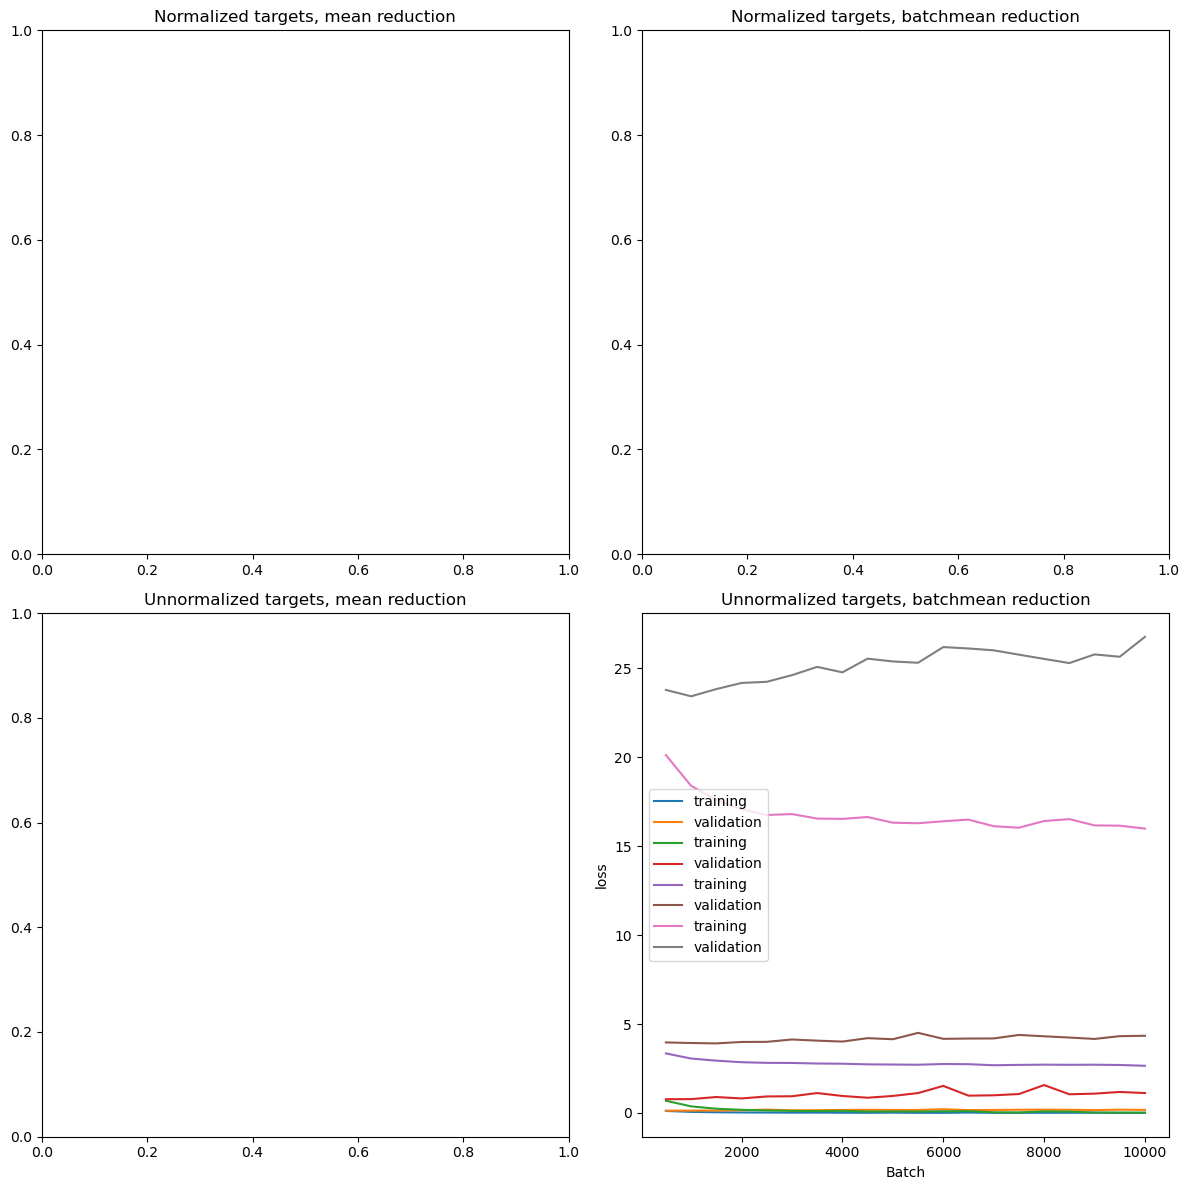

In [19]:
from utils import Trainer
# 1. normalized vs. unnormalized
# 2. mean vs. batchmean
fig, axs = plt.subplots(2, 2, figsize=((12, 12)))

train_small = SpectrogramDataset(metadata_train, n_items=5000,
                                 preloaded=True, normalize_targets=True, random_state=4)
valid_small = SpectrogramDataset(metadata_valid, n_items=1000,
                                 preloaded=True, normalize_targets=True, random_state=4)
torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)

model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
lr = 1e-3
optimizer_class = torch.optim.AdamW
loss_fn = torch.nn.KLDivLoss(reduction="mean")

trainer = Trainer(model, train_loader, valid_loader,
                  optimizer=optimizer_class,
                  criterion=loss_fn,
                  lr=1e-3,
                  writer="auto",
                  model_name="spectrogram_efficientnet_b0_mean_reduction_5000_items")
trainer.train_eval_loop(10_000, 500, 500)
trainer.plot_metrics(ax=axs[0][0])
axs[0][0].set_title("Normalized targets, mean reduction")


torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)
model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
trainer = Trainer(model, train_loader, valid_loader,
                  optimizer=optimizer_class,
                  criterion=loss_fn,
                  lr=1e-3,
                  writer="auto",
                  model_name="spectrogram_efficientnet_b0_batchmean_reduction_5000_items")
trainer.train_eval_loop(10_000, 500, 500)
trainer.plot_metrics(ax=axs[0][1])
axs[0][1].set_title("Normalized targets, batchmean reduction")


train_small = SpectrogramDataset(metadata_train, n_items=5000,
                                 preloaded=True, normalize_targets=False, random_state=4)
valid_small = SpectrogramDataset(metadata_valid, n_items=1000,
                                 preloaded=True, normalize_targets=False, random_state=4)
torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)
model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
loss_fn = torch.nn.KLDivLoss(reduction="mean")
trainer = Trainer(model, train_loader, valid_loader,
                  optimizer=optimizer_class,
                  criterion=loss_fn,
                  lr=1e-3,
                  writer="auto",
                  model_name="spectrogram_efficientnet_b0_unnormalized_targets_mean_reduction_5000_items")
trainer.train_eval_loop(10_000, 500, 500)
trainer.plot_metrics(ax=axs[1][0])
axs[1][0].set_title("Unnormalized targets, mean reduction")


torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)
model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
trainer = Trainer(model, train_loader, valid_loader,
                  optimizer=optimizer_class,
                  criterion=loss_fn,
                  lr=1e-3,
                  writer="auto",
                  model_name="spectrogram_efficientnet_b0_unnormalized_targets_batchmean_reduction_5000_items")
trainer.train_eval_loop(10_000, 500, 500)
trainer.plot_metrics(ax=axs[1][1])
axs[1][1].set_title("Unnormalized targets, batchmean reduction")


From inspecting Tensorboard, it seems that batchmean reduction and normalized targets give the most plausible answer -- confirming Frank's observations. Great! I will use batchmean reduction from now on.

  0%|          | 0/300 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.70E-04


  0%|          | 0/300 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.57E-04


  0%|          | 0/300 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.85E-07


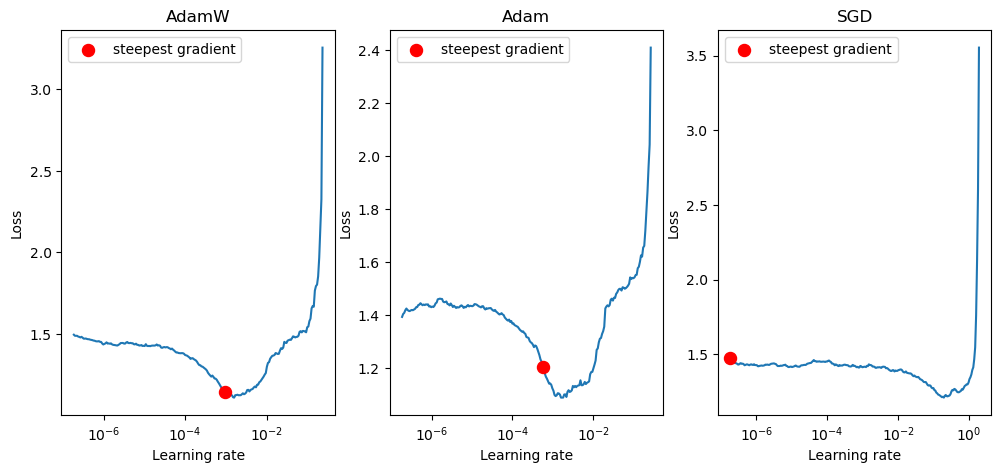

In [31]:
# 3. Different optimizers
# First, find good learning rates
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
train_small = SpectrogramDataset(metadata_train, n_items=5000,
                                 preloaded=True, normalize_targets=True, random_state=4)
valid_small = SpectrogramDataset(metadata_valid, n_items=1000,
                                 preloaded=True, normalize_targets=True, random_state=4)

batch_size = 32
torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)
optims = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD]
optim_names = ["AdamW", "Adam", "SGD"]

for i in range(3):
    model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
    optimizer = optims[i](model.parameters(), lr=1e-7)
    loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
    lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
    lr_finder.range_test(train_loader, end_lr=10, num_iter=300)
    lr_finder.plot(ax=axs[i])
    axs[i].set_title(optim_names[i]);


Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_AdamW_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_Adam_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_SGD_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

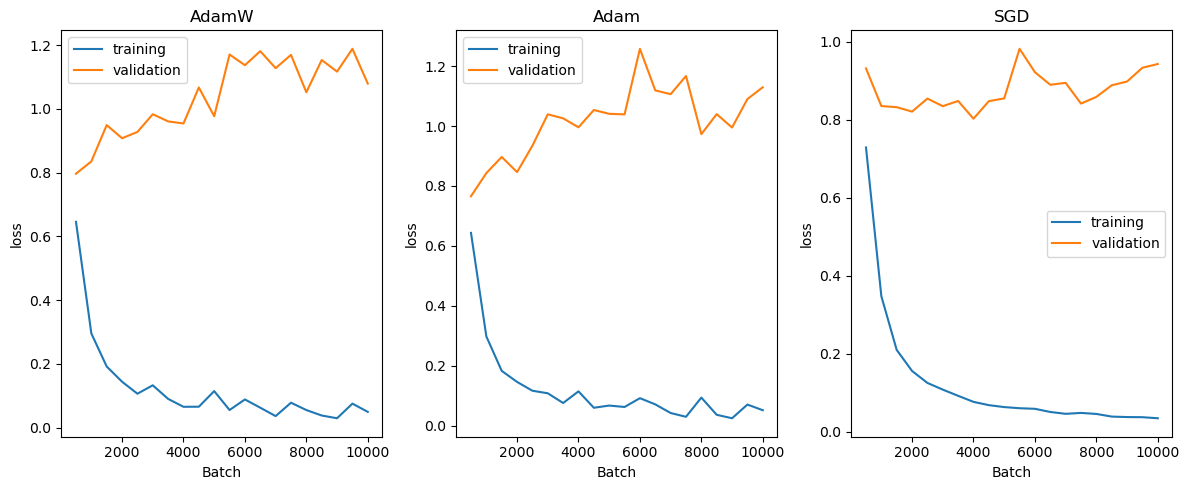

In [32]:
# Now train each optimizer
# I want to save the results from AdamW, since that will be my "a priori best" baseline
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
optims = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD]
optim_names = ["AdamW", "Adam", "SGD"]
lrs = [5e-4, 5e-4, 1e-1]

for i in range(3):
    torch.manual_seed(4)
    train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_small, batch_size=batch_size)
    model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
    optimizer_class = optims[i]
    loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
    if i == 0:
        default_trainer = Trainer(model, train_loader, valid_loader,
                          optimizer=optimizer_class,
                          criterion=loss_fn,
                          lr=lrs[i],
                          writer="auto",
                          model_name=f"spectrogram_efficientnet_b0_{optim_names[i]}_5000_items")
        default_trainer.train_eval_loop(10_000, 500, 500)
        default_trainer.plot_metrics(ax=axs[i])
        axs[i].set_title(optim_names[i])
    else:
        trainer = Trainer(model, train_loader, valid_loader,
                          optimizer=optimizer_class,
                          criterion=loss_fn,
                          lr=lrs[i],
                          writer="auto",
                          model_name=f"spectrogram_efficientnet_b0_{optim_names[i]}_5000_items")
        trainer.train_eval_loop(10_000, 500, 500)
        trainer.plot_metrics(ax=axs[i])
        axs[i].set_title(optim_names[i])

So actually, vanilla SGD is better here. This needs to be rechecked on a larger dataset, since it's not *learning* any faster, just *overfitting less badly*.

  0%|          | 0/300 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.75E-02


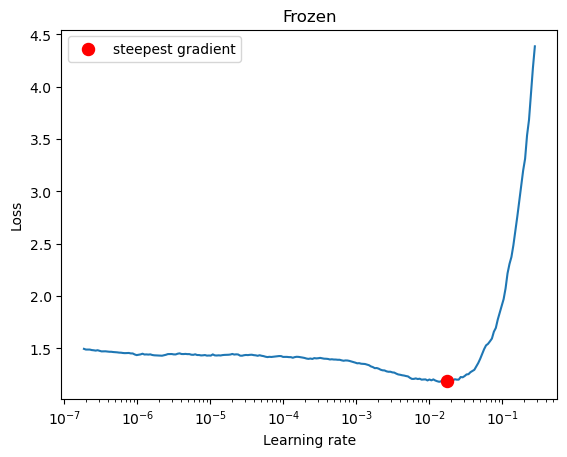

In [36]:
# 4. Frozen vs. unfrozen
torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)
model = Spectrogram_EfficientNet(frozen=True).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7)
loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=300)
lr_finder.plot(ax=plt.gca())
plt.gca().set_title("Frozen");

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_frozen_5000_items.


Training:   0%|          | 0/10640 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Unfrozen')

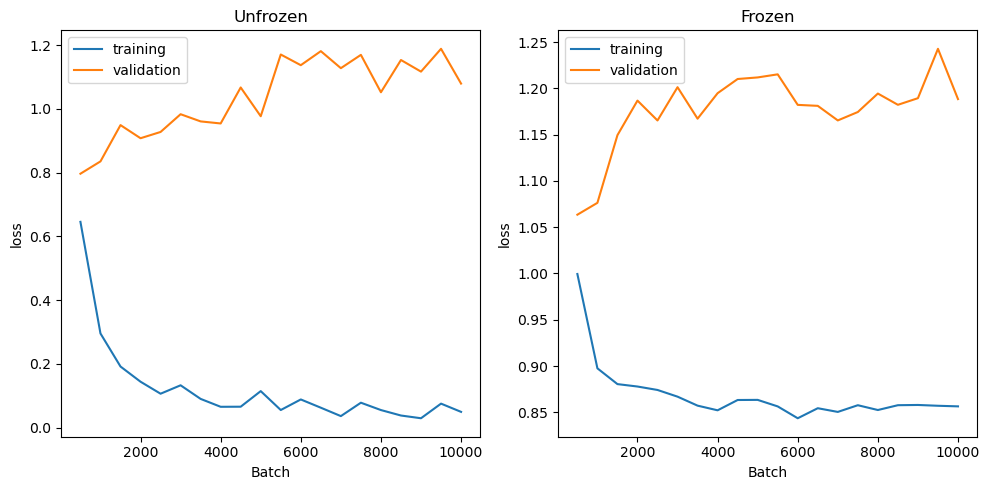

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
torch.manual_seed(4)
train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_small, batch_size=batch_size)
model = Spectrogram_EfficientNet(frozen=True).to(DEVICE)
optimizer_class = torch.optim.AdamW
loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
trainer = Trainer(model, train_loader, valid_loader,
                  optimizer=optimizer_class,
                  criterion=loss_fn,
                  lr=3e-3,
                  writer="auto",
                  model_name=f"spectrogram_efficientnet_b0_frozen_5000_items")
trainer.train_eval_loop(10_000, 500, 500)
trainer.plot_metrics(ax=axs[1])
axs[1].set_title("Frozen")

default_trainer.plot_metrics(ax=axs[0])
axs[0].set_title("Unfrozen")

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_batch_size_16_5000_items.


Training:   0%|          | 0/22520 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_batch_size_64_5000_items.


Training:   0%|          | 0/5160 [00:00<?, ?it/s]

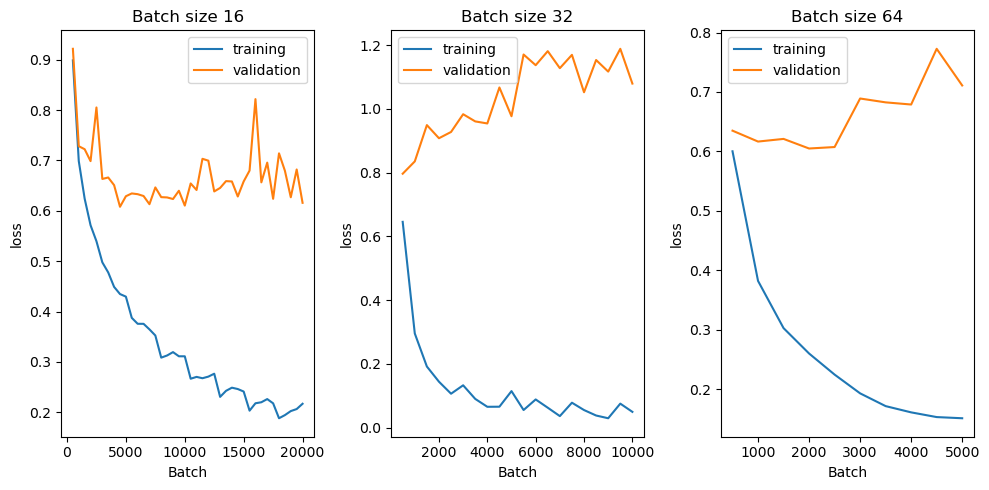

In [42]:
# 5. Different batch sizes
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
batch_sizes = [16, 32, 64]
for i in range(3):
    if batch_sizes[i] == 32:
        default_trainer.plot_metrics(ax=axs[i])
        axs[i].set_title("Batch size 32")
        continue
    batch_size = batch_sizes[i]
    torch.manual_seed(4)
    train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_small, batch_size=batch_size)
    model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
    optimizer_class = torch.optim.AdamW
    loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
    trainer = Trainer(model, train_loader, valid_loader,
                      optimizer=optimizer_class,
                      criterion=loss_fn,
                      lr=1e-3,
                      writer="auto",
                      model_name=f"spectrogram_efficientnet_b0_batch_size_{batch_size}_5000_items")
    trainer.train_eval_loop(10_000 * 32 // batch_size, 500, 500)
    trainer.plot_metrics(ax=axs[i])
    axs[i].set_title(f"Batch size {batch_size}")

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_5000_items.


Training:   0%|          | 0/42560 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_10000_items.


Training:   0%|          | 0/42560 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_20000_items.


Training:   0%|          | 0/42560 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_40000_items.


Training:   0%|          | 0/42560 [00:00<?, ?it/s]

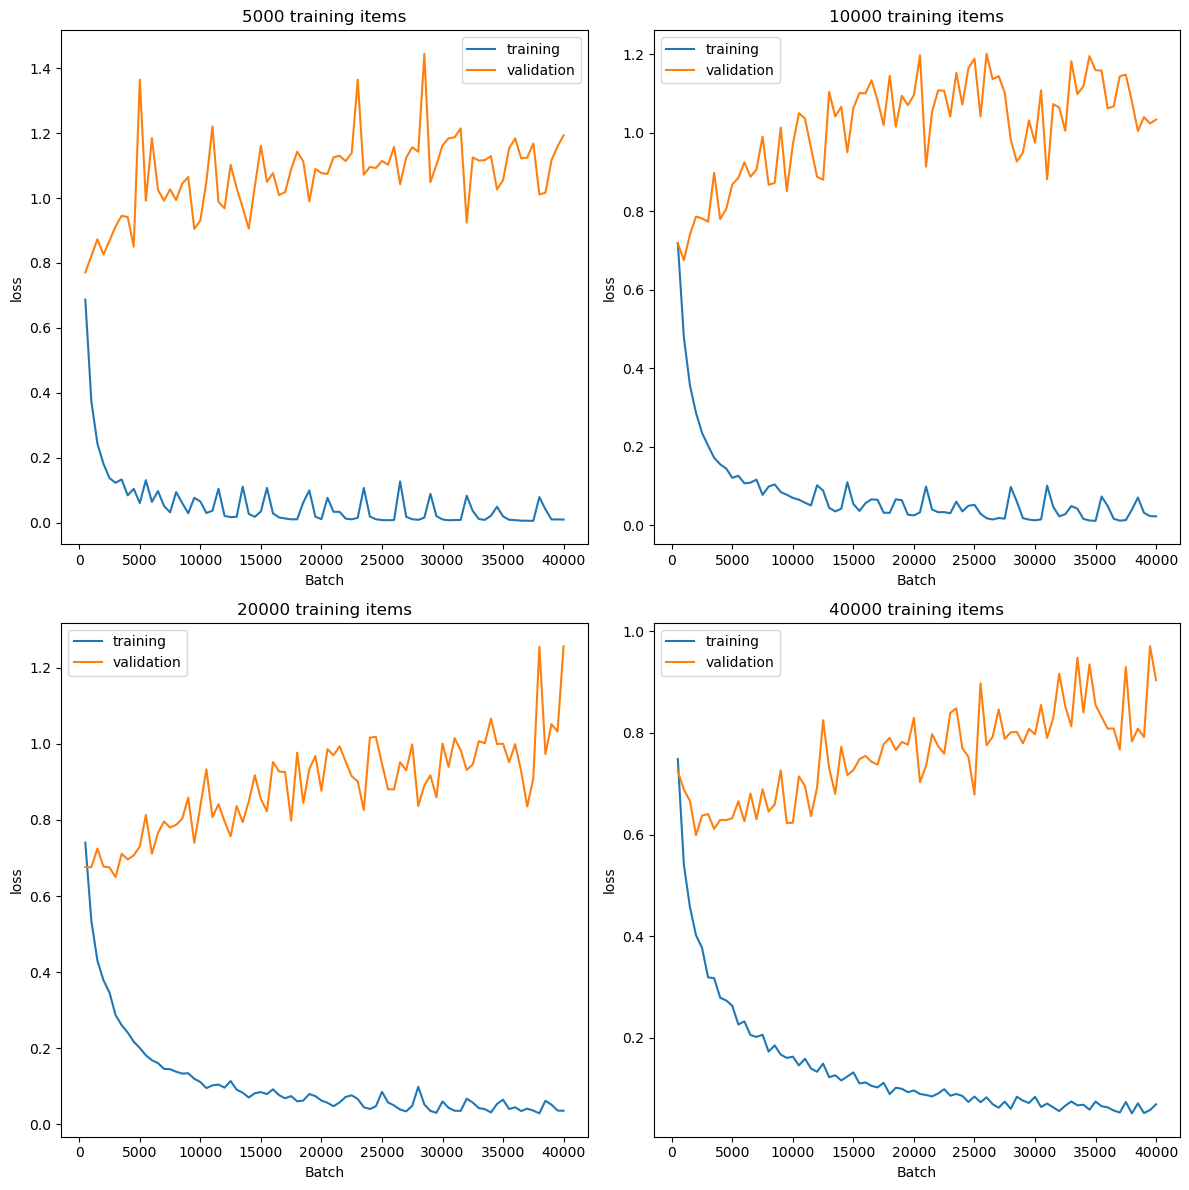

In [43]:
# 6. Different training set sizes
# It actually makes sense to train for longer here...
# I will keep the validation set constant
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
batch_size = 32
valid_loader = DataLoader(valid_small, batch_size=batch_size)
training_set_sizes = [5000, 10000, 20000, 40000]
for i in range(4):
    training_set_size = training_set_sizes[i]
    train_small = SpectrogramDataset(metadata_train, n_items=training_set_size,
                                     preloaded=True, normalize_targets=True, random_state=4)
    torch.manual_seed(4)
    train_loader = DataLoader(train_small, batch_size=batch_size, shuffle=True)
    model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
    optimizer_class = torch.optim.AdamW
    loss_fn = torch.nn.KLDivLoss(reduction="batchmean")
    trainer = Trainer(model, train_loader, valid_loader,
                      optimizer=optimizer_class,
                      criterion=loss_fn,
                      lr=1e-3,
                      writer="auto",
                      model_name=f"spectrogram_efficientnet_b0_{training_set_size}_items")
    trainer.train_eval_loop(40_000, 500, 500)
    trainer.plot_metrics(ax=axs[i])
    axs[i].set_title(f"{training_set_size} training items")


My observations:
- For the small dataset, SGD seems to outperform Adam and AdamW, for reasons I don't understand. The training curves are the same, but the overfitting for SGD is slower and less severe.
- It's predictably better to unfreeze the pretrained weights, but not ridiculously so -- worth about 0.05 points of validation loss. The most interesting thing is that the frozen network is unable to converge to 0 loss on the training set, but doesn't do much worse on the validation set.
- My "default" batch size of 32 was weirdly *worse* than both 16 and 64. This needs further study on a larger dataset, and with SGD. A batch size of 16 obviously results in slower training, but it's possibly worth it if it really gets this significant a boost.
- Increasing the size of the training set still resulted in divergence of the training and validation curves, but the final validation loss is lowered with a larger training set.

I still need to examine:
1. The effect of discriminative learning rates,
2. The effect of changing batch size on models trained with SGD on larger datasets,
3. More complex versions of the EfficientNet architecture.

For now, I'm going to do a long training run using the best-so-far hyperparameters and the full dataset.

  0%|          | 0/300 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.06E-01


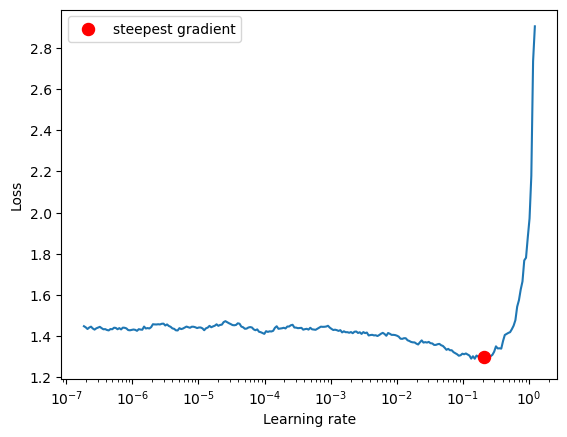

In [44]:

train_dset = SpectrogramDataset(metadata_train, preloaded=True, normalize_targets=True)
valid_dset = SpectrogramDataset(metadata_valid, preloaded=True, normalize_targets=True)

batch_size = 16
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size)

model = Spectrogram_EfficientNet(frozen=False).to(DEVICE)
optimizer_class = torch.optim.SGD
loss_fn = torch.nn.KLDivLoss(reduction="batchmean")

optimizer = optimizer_class(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=300)
lr_finder.plot(ax=plt.gca())
lr_finder.reset();


In [45]:
lr = 1e-1
trainer = Trainer(model, train_loader, valid_loader,
                  optimizer=optimizer_class,
                  criterion=loss_fn,
                  lr=lr,
                  writer="auto",
                  model_name="spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset")

trainer.train_eval_loop(500_000, 500, 500, save_period=10_000)
trainer.plot_metrics()

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-03-23/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset.


Training:   0%|          | 0/1000000 [00:00<?, ?it/s]

Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset_10000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset_20000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset_30000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset_40000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset_50000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset_60000_batches.pt.


KeyboardInterrupt: 

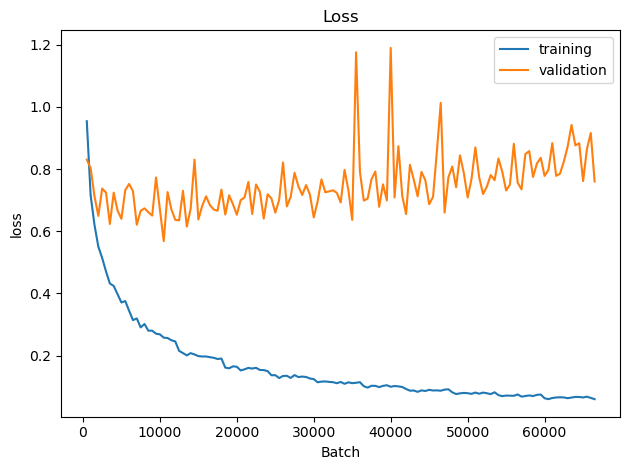

In [46]:
trainer.plot_metrics()

I interrupted the training early, since the model was overfitting. The 10,000 epoch checkpoint got a leaderboard score of 0.88.